In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
BASE_DATA_PATH = os.path.join("out")
OUTPUT_FOLDER = os.path.join("benchmark_plots")
TIMES_IN_MS = False

def get_dataset_file(cloud_name, timestamp = "latest", data_path = BASE_DATA_PATH):
    # Get all CSV files in the folder
    data_folder = os.path.join(data_path, cloud_name)
    file_path = os.path.join(data_folder, "approx_searches.csv")
    df = pd.read_csv(file_path)
    if df is None:
        FileNotFoundError(f"File 'approx_searches.csv' not found in folder: {data_folder}")
    # Convert times to milliseconds
    if TIMES_IN_MS:
        df['mean'] = df['mean'] * 1000
        df['stdev'] = df['stdev'] * 1000
        df['warmup_time'] = df['warmup_time'] * 1000
    return df

def read_multiple_datasets(clouds_datasets, data_path = BASE_DATA_PATH):
    dfs = {}
    for cloud, dataset in clouds_datasets.items():
        dfs[cloud] = get_dataset_file(cloud, "latest", data_path)
    return dfs

def output_fig(fig, filename):
    fig.savefig(os.path.join(OUTPUT_FOLDER, filename + ".pdf"), dpi=300, bbox_inches='tight')
    plt.close(fig)

In [2]:
import scienceplots
plt.style.use(["science", "grid"])
plt.rcParams.update({
    'font.size': 14,
    'axes.labelsize': 24,
    #'axes.titlesize': 12,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 9,
    'legend.title_fontsize': 14,  
    
    'axes.grid': True,
    'axes.grid.axis': 'y',  # Only horizontal grid lines
    'grid.linestyle': '-',  # Solid line
    'grid.linewidth': 0.4,  # Very thin grid lines
    'grid.color': '#CCCCCC',  # Light gray grid
    
    'axes.axisbelow': True,
    'figure.figsize': (6, 4),  # Standard publication-friendly figure size
    'figure.dpi': 100, 
    #'figure.dpi': 300, 
    
    'lines.linewidth': 1.0,  # Consistent line thickness
    'lines.markersize': 4,  # Consistent marker size

    'figure.facecolor': 'white',  # Background color of the figure
    'figure.edgecolor': 'white',   # Edge color of the figure
})


In [3]:
from matplotlib.colors import TwoSlopeNorm
from matplotlib import cm

# Plot points
def plot_cloud(cloud, category, tolerance, data_path=BASE_DATA_PATH):
    df = get_dataset_file(cloud, "latest", data_path)
    """Plots a 3D point cloud for a given category and tolerance."""
    subset = df[(df["upper"] == category) & (df["tolerance"] == tolerance)]
    print(f"Tolerance {tolerance} with bound {category} size: {subset.size}")

    # Create figure and 3D axis
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Apply diverging color map
    cmap = cm.coolwarm
    max_tol = df['tolerance'].max()
    norm = Normalize(vmin=-max_tol, vmax=max_tol)
    
    # Determine sign based on category
    tol = tolerance if category == "upper" else -tolerance
    color = cmap(norm(tol))

    ax.scatter(subset["x"], subset["y"], subset["z"], c=[color], marker="o", s=2, rasterized=True)

    # Labels and title
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("$z$")
    ax.set_title(f"3D Point Cloud - Tolerance: {tolerance}, Bound: {category}")

    return fig


Tolerance 0.0 with bound exact size: 414100
Tolerance 25 with bound lower size: 215635
Tolerance 50 with bound lower size: 48870
Tolerance 100 with bound lower size: 0
Tolerance 25 with bound upper size: 783975
Tolerance 50 with bound upper size: 1128675
Tolerance 75 with bound upper size: 1128675


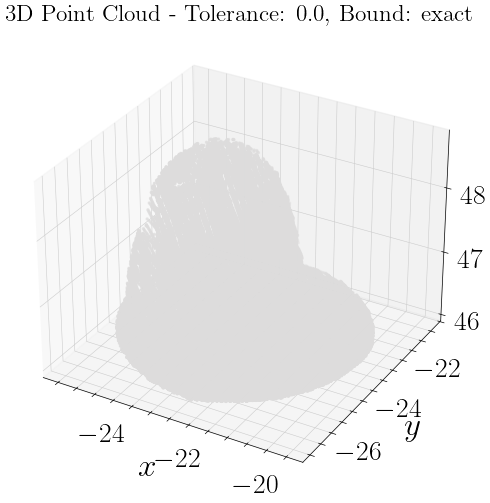

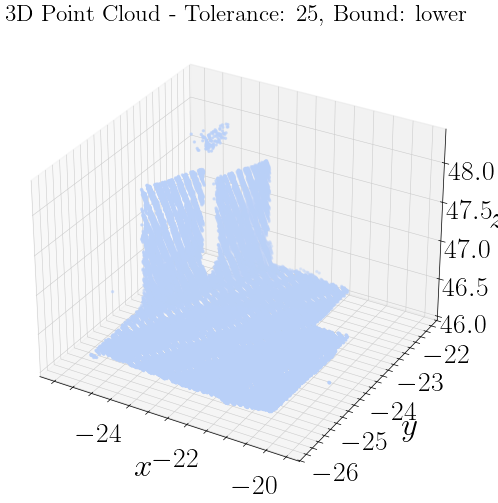

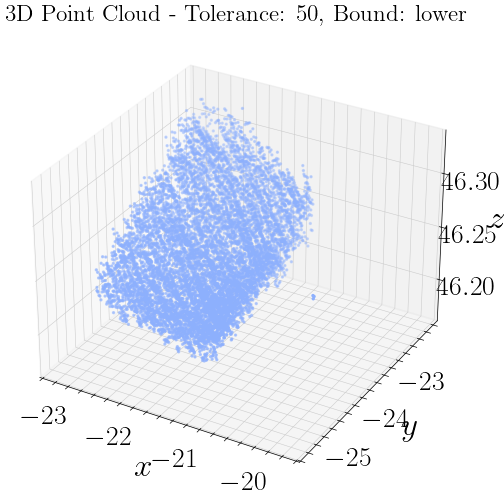

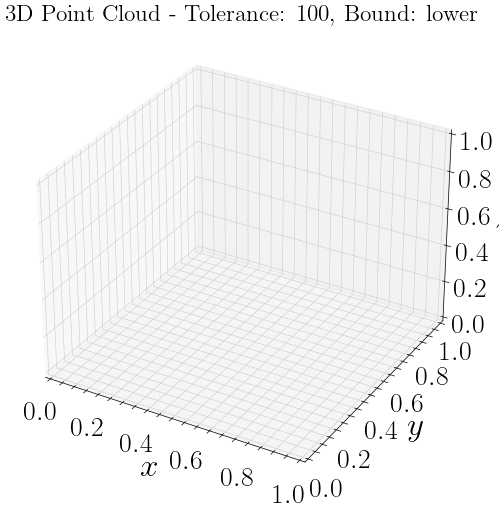

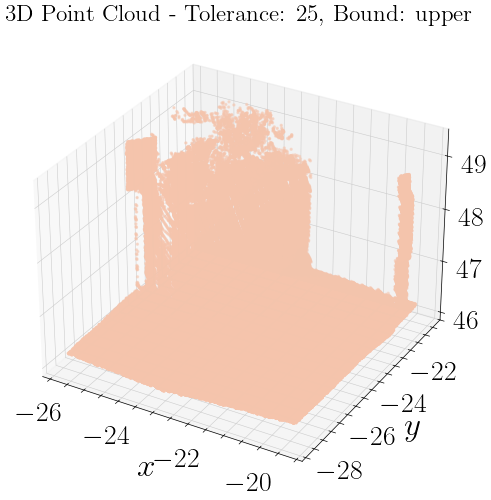

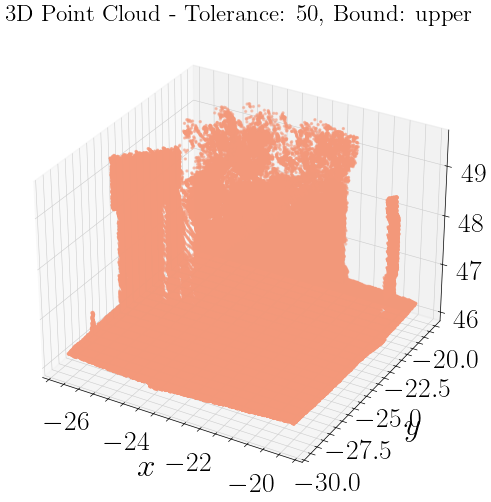

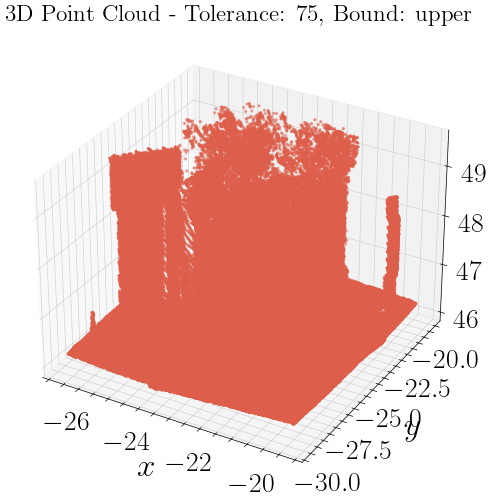

In [4]:
fig = plot_cloud("Lille_0", "exact", 0.0)
fig = plot_cloud("Lille_0", "lower", 25)
fig = plot_cloud("Lille_0", "lower", 50)
fig = plot_cloud("Lille_0", "lower", 100)
fig = plot_cloud("Lille_0", "upper", 25)
fig = plot_cloud("Lille_0", "upper", 50)
fig = plot_cloud("Lille_0", "upper", 75)

In [12]:
import numpy as np
from matplotlib.colors import Normalize
from matplotlib import cm
import seaborn as sns
def plot_approx_neighbors(cloud, data_path=BASE_DATA_PATH):
    df = get_dataset_file(cloud, "latest", data_path)

    # Invert tolerance for lower bounds
    df.loc[df["upper"] == "lower", "tolerance"] *= -1

    # Sort by absolute tolerance ascending → prioritize closer neighborhoods
    df["point_key"] = list(zip(df["x"], df["y"], df["z"]))
    df = df.loc[df["tolerance"].argsort(kind="stable")]

    # Drop duplicates: keep first occurrence (closest match)
    df = df.drop_duplicates(subset="point_key", keep="first")

    # Normalize colors
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    max_tol = df["tolerance"].abs().max()
    norm = Normalize(vmin=-max_tol, vmax=max_tol)
    colors = cmap(norm(df["tolerance"].values))

    # Rasterized 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(df["x"], df["y"], df["z"], c=colors, s=2, rasterized=True)

    # Labels and colorbar
    ax.set_xlabel("$x$")
    ax.set_ylabel("$y$")
    ax.set_zlabel("$z$")
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
    cbar.ax.tick_params(labelsize=24)
    cbar.set_label("$tol$", fontsize=24)
    pdf_path = os.path.join(os.path.join(os.path.expanduser("~"), "tfg_info", "figuras", "reorder"), "approx_searches.pdf")
    plt.savefig(pdf_path, dpi=300, bbox_inches='tight', facecolor='white', format='pdf')
    plt.show()


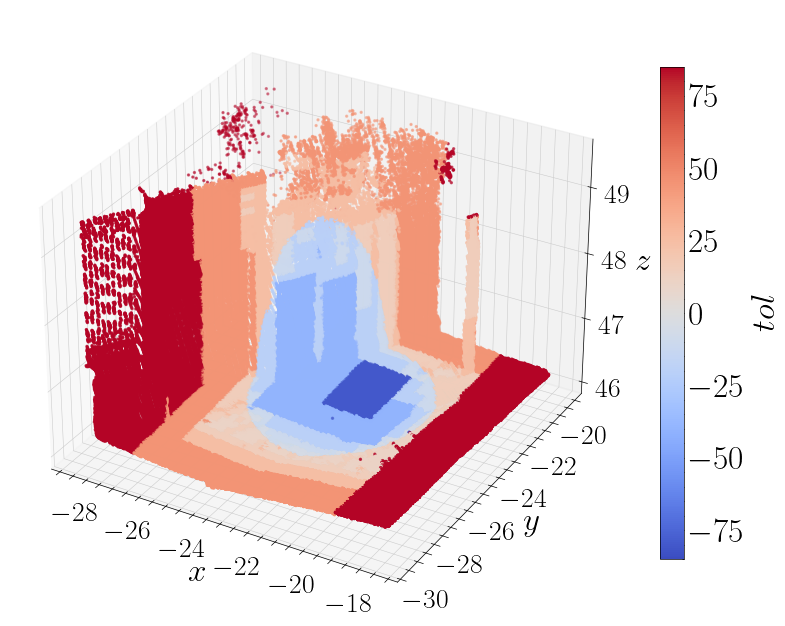

In [13]:
plot_approx_neighbors("Lille_0")